# Credit Card Client Segmentation

In [1]:
import pandas as pd
import numpy as np
from itertools import compress

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
import seaborn as sns

In this project, I’ll play the role of a data scientist working for a credit card company. The dataset contains information about the company’s clients and we're asked to help segment them into different groups in order to apply different business strategies for each type of customer. 

For instance, the company could provide higher credit limits for cc that use the card a lot, but spend little money, or even create incentives for those with high income who don't use the card as much as the company expects. In order to apply different strategies, the company needs different groups of cc.

Luckily, the data engineering team has already cleaned most of the data so we can focus on building the best possible model to segment the data. Also, in a planning meeting with the Data Science coordinator, it was decided that we should use the K-means algorithm to segment the data.

The company expects to receive a group for each client and an explanation of the characteristics of each group and the main points that make them different.

In order to use the algorithm properly and achieve all the goals that the company has set for us, we'll go through the following steps:

- Analyze the dataset;
- Prepare the data for modeling;
- Find an appropriate number of clusters;
- Segment the data;
- Interpret and explain the results.

Here's the data dictionary:

- customer_id: unique identifier for each customer.
- age: customer age in years.
- gender: customer gender (M or F).
- dependent_count: number of dependents of each customer.
- education_level: level of education ("High School", "Graduate", etc.).
- marital_status: marital status ("Single", "Married", etc.).
- estimated_income: the estimated income for the customer projected by the data science team.
- months_on_book: time as a customer in months.
- total_relationship_count: number of times the customer contacted the company.
- months_inactive_12_mon: number of months the customer did not use the credit card in the last 12 months.
- credit_limit: customer's credit limit.
- total_trans_amount: the overall amount of money spent on the card by the customer.
- total_trans_count: the overall number of times the customer used the card.
- avg_utilization_ratio: daily average utilization ratio.


## Importing and inspecting data

In [2]:
cc = pd.read_csv("../Datasets/customer_segmentation.csv")

In [3]:
print(print(cc.shape))
print(cc.info())

(10127, 14)
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  fl

In [4]:
cc.head()

customer_id  age gender  dependent_count education_level marital_status  \
0    768805383   45      M                3     High School        Married   
1    818770008   49      F                5        Graduate         Single   
2    713982108   51      M                3        Graduate        Married   
3    769911858   40      F                4     High School        Unknown   
4    709106358   40      M                3      Uneducated        Married   

   estimated_income  months_on_book  total_relationship_count  \
0             69000              39                         5   
1             24000              44                         6   
2             93000              36                         4   
3             37000              34                         3   
4             65000              21                         5   

   months_inactive_12_mon  credit_limit  total_trans_amount  \
0                       1       12691.0                1144   
1                       1        8256.0                1291   
2                       1        3418.0                1887   
3                       4        3313.0                1171   
4                       1        4716.0                 816   

   total_trans_count  avg_utilization_ratio  
0                 42                  0.061  
1                 33                  0.105  
2                 20                  0.000  
3                 20                  0.760  
4                 28                  0.000

In [5]:
numerical_vars = ['age', 'estimated_income', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon', 'credit_limit', 'total_trans_amount', 'total_trans_count', 'avg_utilization_ratio']
categorical_vars = ['gender', 'education_level', 'marital_status']

In [6]:
print(f"Missing Data: \n{cc.isnull().sum()}")

Missing Data: 
customer_id                 0
age                         0
gender                      0
dependent_count             0
education_level             0
marital_status              0
estimated_income            0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
credit_limit                0
total_trans_amount          0
total_trans_count           0
avg_utilization_ratio       0
dtype: int64


In [7]:
print(cc.describe())

        customer_id           age  dependent_count  estimated_income  \
count  1.012700e+04  10127.000000     10127.000000      10127.000000   
mean   7.391776e+08     46.325960         2.346203      62078.206774   
std    3.690378e+07      8.016814         1.298908      39372.861291   
min    7.080821e+08     26.000000         0.000000      20000.000000   
25%    7.130368e+08     41.000000         1.000000      32000.000000   
50%    7.179264e+08     46.000000         2.000000      50000.000000   
75%    7.731435e+08     52.000000         3.000000      80000.000000   
max    8.283431e+08     73.000000         5.000000     200000.000000   

       months_on_book  total_relationship_count  months_inactive_12_mon  \
count    10127.000000              10127.000000            10127.000000   
mean        35.928409                  3.812580                2.341167   
std          7.986416                  1.554408                1.010622   
min         13.000000                  1.000000    

In [8]:
cc['gender'].value_counts(normalize=True)

F    0.529081
M    0.470919
Name: gender, dtype: float64

In [9]:
for col in categorical_vars: 
    print(cc[col].value_counts(), '\n')

F    5358
M    4769
Name: gender, dtype: int64 

Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: education_level, dtype: int64 

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64 



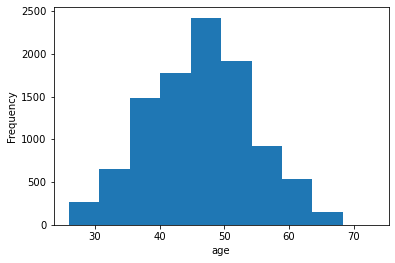

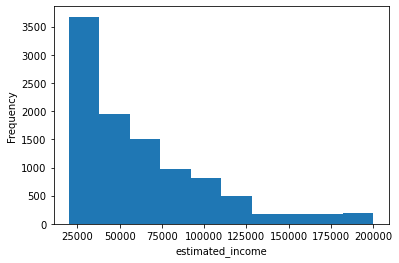

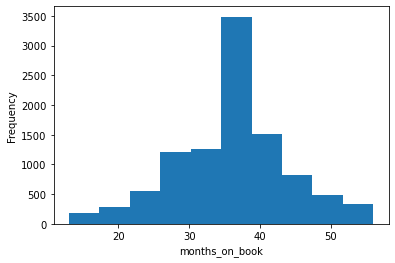

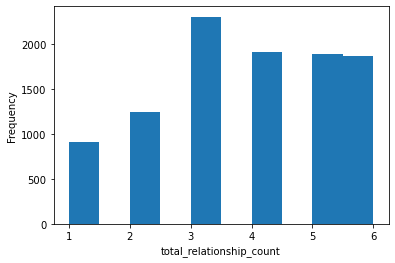

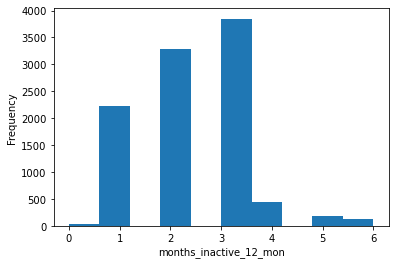

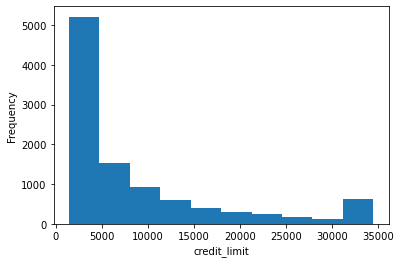

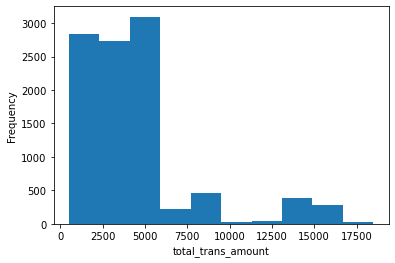

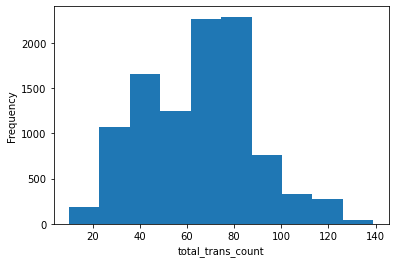

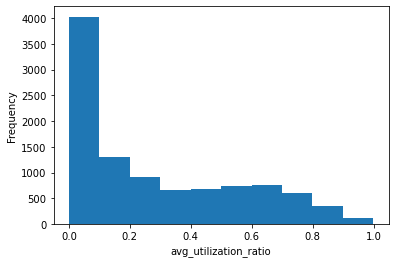

In [10]:
for col in numerical_vars: 
    cc[col].plot.hist()
    plt.xlabel(col)
    plt.show()

## Clean data

### Copy df and drop customer ID variable

In [11]:
cc_modif = cc.copy()
cc_modif.drop(columns='customer_id', inplace=True) 

### Deal with categorical variables

In [12]:
cc_modif['gender'] = cc_modif['gender'].map({'F':0, 'M': 1})
cc_modif['education_level'] = cc_modif['education_level'].map({'Uneducated':0, 'High School':1, 'College':2, 'Graduate':3, 'Post-Graduate':4, 'Doctorate':5})
cc_modif = pd.get_dummies(data=cc_modif, columns=['marital_status'], drop_first=True)

### Scale data

In [13]:
cc_modif.head()

age  gender  dependent_count  education_level  estimated_income  \
0   45       1                3                1             69000   
1   49       0                5                3             24000   
2   51       1                3                3             93000   
3   40       0                4                1             37000   
4   40       1                3                0             65000   

   months_on_book  total_relationship_count  months_inactive_12_mon  \
0              39                         5                       1   
1              44                         6                       1   
2              36                         4                       1   
3              34                         3                       4   
4              21                         5                       1   

   credit_limit  total_trans_amount  total_trans_count  avg_utilization_ratio  \
0       12691.0                1144                 42                  0.061   
1        8256.0                1291                 33                  0.105   
2        3418.0                1887                 20                  0.000   
3        3313.0                1171                 20                  0.760   
4        4716.0                 816                 28                  0.000   

   marital_status_Married  marital_status_Single  marital_status_Unknown  
0                       1                      0                       0  
1                       0                      1                       0  
2                       1                      0                       0  
3                       0                      0                       1  
4                       1                      0                       0

In [14]:
std_scaler = StandardScaler()
std_scaler.fit(cc_modif)
cc_scaled = pd.DataFrame(std_scaler.transform(cc_modif), columns=cc_modif.columns)
cc_scaled.head()

age    gender  dependent_count  education_level  estimated_income  \
0 -0.165406  1.059956         0.503368        -0.752211          0.175810   
1  0.333570 -0.943436         2.043199         0.662787         -0.967166   
2  0.583058  1.059956         0.503368         0.662787          0.785397   
3 -0.789126 -0.943436         1.273283        -0.752211         -0.636973   
4 -0.789126  1.059956         0.503368        -1.459710          0.074212   

   months_on_book  total_relationship_count  months_inactive_12_mon  \
0        0.384621                  0.763943               -1.327136   
1        1.010715                  1.407306               -1.327136   
2        0.008965                  0.120579               -1.327136   
3       -0.241473                 -0.522785                1.641478   
4       -1.869317                  0.763943               -1.327136   

   credit_limit  total_trans_amount  total_trans_count  avg_utilization_ratio  \
0      0.446622           -0.959707          -0.973895              -0.775882   
1     -0.041367           -0.916433          -1.357340              -0.616276   
2     -0.573698           -0.740982          -1.911206              -0.997155   
3     -0.585251           -0.951758          -1.911206               1.759686   
4     -0.430877           -1.056263          -1.570365              -0.997155   

   marital_status_Married  marital_status_Single  marital_status_Unknown  
0                1.077338              -0.798507               -0.282609  
1               -0.928214               1.252337               -0.282609  
2                1.077338              -0.798507               -0.282609  
3               -0.928214              -0.798507                3.538459  
4                1.077338              -0.798507               -0.282609

## Analyze data

### Determine optimal number of clusters

In [15]:
def plot_elbow_curve(df, max_clusters=10):
    inertias = []
    for i in range(2,max_clusters+1):
        m = KMeans(n_clusters=i)
        m.fit_predict(df)
        inertias.append(m.inertia_)
        
    plt.plot(range(2,max_clusters+1), inertias, marker='o')
    plt.show()
    
    return inertias

In [16]:
def plot_inertia_diffs(_list):
    inertias_diffs = [_list[i]-_list[i+1] for i in range(0,len(_list)-1)]
    plt.plot(range(3,len(inertias_diffs)+3),inertias_diffs, marker='o')
    plt.xticks(np.arange(3,len(inertias_diffs)+3,1))
    plt.ylabel("cluster interia difference")
    plt.xlabel("end cluster in difference")
    plt.show()

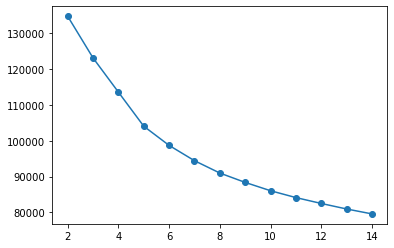

In [17]:
inertias = plot_elbow_curve(cc_scaled, 14)

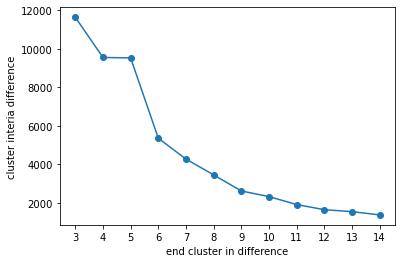

In [18]:
plot_inertia_diffs(inertias)

Inspecting the inertia curve, ther is not a clear elbow to help decide the optimal number of clusters. Looking at the absolute differences between intertia at each cluster helps, however, showing that there is a much larger drop in cluster difference from 5 to 6 clusters. Therefore, 6 or 7 clusters should be a good amount.

### Fit optimal cluster model

In [19]:
model = KMeans(n_clusters=6)
clusters = model.fit_predict(cc_scaled)

In [20]:
cc['Cluster'] = clusters+1
cc['Cluster'].value_counts()

1    2815
4    2448
5    1782
3    1444
2     909
6     729
Name: Cluster, dtype: int64

### Interpret clusters

#### Inspect categorical variables

gender  Cluster      F      M
4             5  0.033  0.967
1             2  0.350  0.650
5             6  0.517  0.483
2             3  0.610  0.390
3             4  0.704  0.296
0             1  0.710  0.290


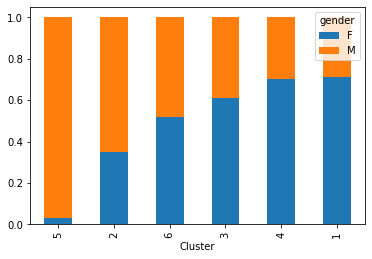

education_level  Cluster  College  Doctorate  Graduate  High School  \
5                      6    0.112      0.041     0.354        0.240   
1                      2    0.113      0.046     0.355        0.241   
2                      3    0.114      0.064     0.366        0.227   
3                      4    0.115      0.056     0.366        0.232   
4                      5    0.119      0.051     0.351        0.245   
0                      1    0.124      0.049     0.375        0.222   

education_level  Post-Graduate  Uneducated  
5                        0.080       0.173  
1                        0.055       0.189  
2                        0.055       0.175  
3                        0.059       0.173  
4                        0.058       0.177  
0                        0.064       0.166  


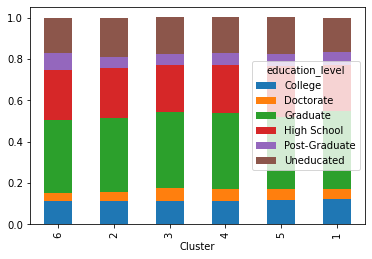

marital_status  Cluster  Divorced  Married  Single  Unknown
3                     4     0.000    0.000   1.000    0.000
5                     6     0.000    0.000   0.000    1.000
2                     3     0.075    0.623   0.302    0.000
1                     2     0.089    0.473   0.416    0.022
4                     5     0.111    0.507   0.382    0.000
0                     1     0.129    0.871   0.000    0.000


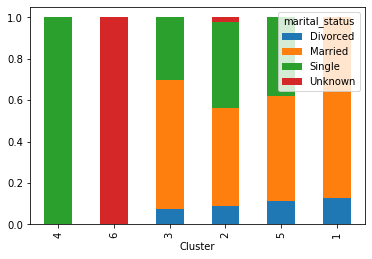

In [21]:
for var in categorical_vars:
    plot_df = round(pd.crosstab(cc['Cluster'], cc[var],normalize='index'),3)
    plot_df.reset_index(inplace=True)
    plot_df = plot_df.sort_values(plot_df.columns[1])
    print(plot_df)
    
    plot_df.set_index('Cluster').plot(kind='bar', stacked=True)
    plt.show()

Takeaways:
- Our plot of gender by cluster reveals that cluster 3 is predominately male, clusters 2 and 4 have a similarly high proportion of females (~0.71), and clusters 6, 1, and 5 have more middling gender ratios.
- Our plot marital status by cluster reveals that cluster 1 is predominately unknown, cluster 4 is predominately single, cluster 2 is predominateliy married, and clusters 5, 6, and 3 are less distinguishable.
- Of the categorical variables, education level was the least informative, with each cluster being roughly evenly split between levels.

#### Inspect numerical vars

In [22]:
numerical_vars

['age',
 'estimated_income',
 'months_on_book',
 'total_relationship_count',
 'months_inactive_12_mon',
 'credit_limit',
 'total_trans_amount',
 'total_trans_count',
 'avg_utilization_ratio']

              mean       std
Cluster                     
1        43.195027  6.196725
2        45.322332  7.768580
3        57.290166  4.467750
4        43.674428  7.373106
5        46.813131  6.389684
6        45.662551  6.767223


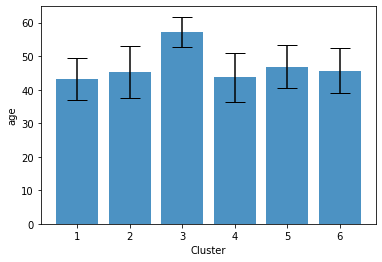

                  mean           std
Cluster                             
1         45853.641208  23391.918281
2         68929.592959  39043.569557
3         50718.836565  27477.021807
4         46875.000000  24796.810158
5        114486.531987  39274.507055
6         61629.629630  37097.954684


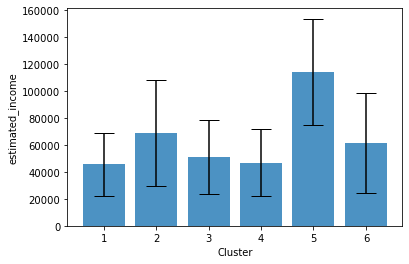

              mean       std
Cluster                     
1        32.991474  6.216189
2        35.167217  7.816634
3        46.116343  5.931490
4        33.523693  7.244479
5        36.264310  6.520064
6        35.292181  7.168188


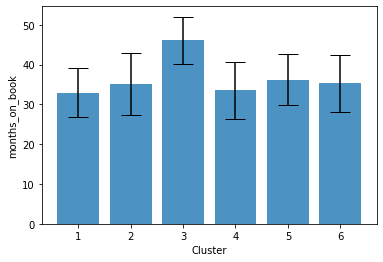

             mean       std
Cluster                    
1        3.959147  1.476215
2        2.176018  1.193705
3        4.076870  1.441987
4        3.921160  1.508427
5        4.053311  1.473695
6        3.810700  1.605227


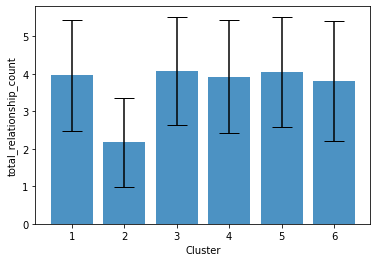

             mean       std
Cluster                    
1        2.330373  1.013195
2        2.194719  0.971247
3        2.440443  1.119932
4        2.329248  0.967943
5        2.370932  0.967703
6        2.336077  1.042148


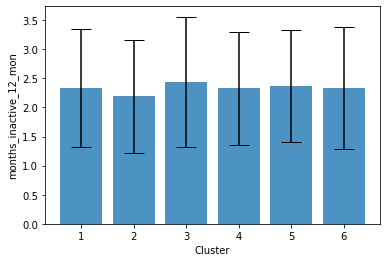

                 mean           std
Cluster                            
1         4369.838082   3485.482245
2        14684.547855  10796.584499
3         4877.454709   4131.158093
4         4928.320833   4454.208228
5        20192.733333  10154.817546
6         9156.957613   9292.818787


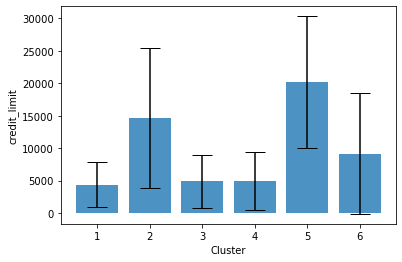

                 mean          std
Cluster                           
1         3556.047957  1572.057018
2        13313.273927  2862.679661
3         2889.609418  1539.583927
4         3762.898693  1567.530015
5         3294.727273  1896.964685
6         4434.519890  2855.105697


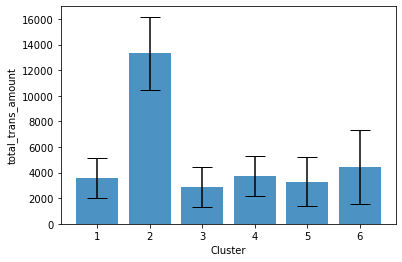

               mean        std
Cluster                       
1         61.829485  19.511975
2        106.880088  12.609080
3         53.033241  20.670339
4         65.299428  17.767277
5         56.790123  19.741102
6         65.825789  21.297890


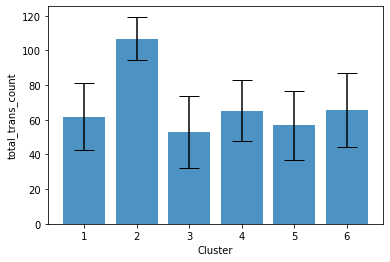

             mean       std
Cluster                    
1        0.355563  0.288081
2        0.167058  0.171975
3        0.348724  0.289208
4        0.329063  0.289005
5        0.074538  0.094243
6        0.259469  0.269050


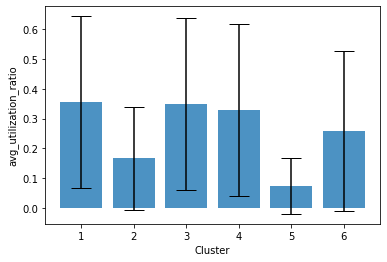

In [23]:
var_sums = {}
for var in numerical_vars:
    var_sums[var] = cc.groupby('Cluster')[var].agg(['mean', 'std'])
    print(var_sums[var])
    
    plt.bar(var_sums[var].index, var_sums[var]['mean'], yerr=var_sums[var]['std'], capsize=10, alpha=.8)
    plt.ylabel(var)
    plt.xlabel('Cluster')
    plt.show()

Observing mean differences across clusters reveals several distinguishing factors for clusters: 
- Cluster 5 has a higher average age and months on book than other clusters, and the others are similar to each other.
- Cluster 3 has a higher average estimated income than other clusters, and the others are similar to each other.
- Cluster 6 has a lower average total relationship count, higher average total transaction count, and higher average total transaction amount than other clusters, and the others are similar to each other in all these respects.
- Credit limit has roughly this relationship between clusters, from high to low, where {} indicates no apparent difference among clusters: 3, 6, 1, {2,4,5}.
- Average utilization ratio has roughly this relationship between clusters, from high to low, where {} indicates no apparent difference among clusters: {2,4,5}, 1, 6, 3.
- Months inactive does not distinguish clusters

Now let's plot the raw variables and their summary statistics:

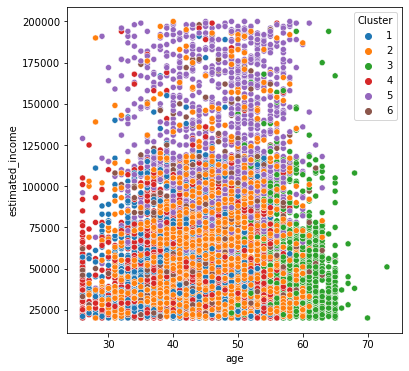

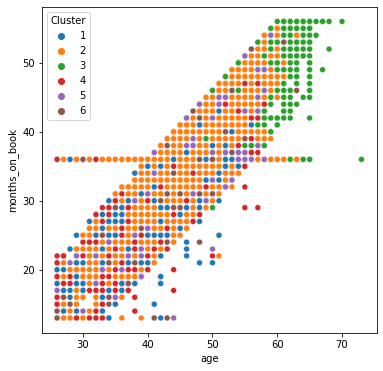

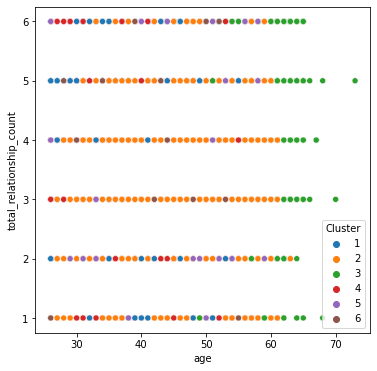

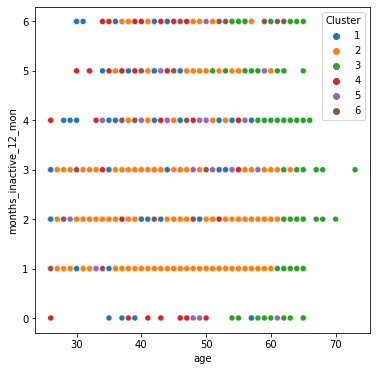

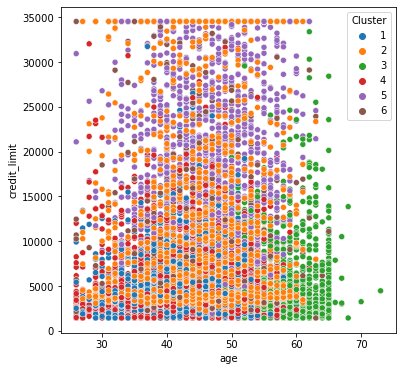

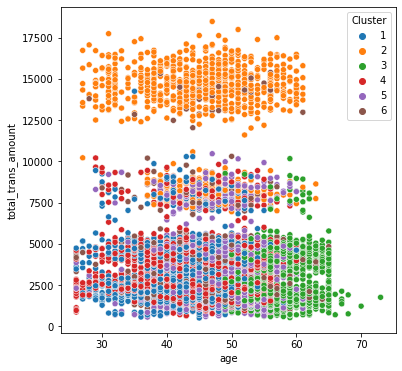

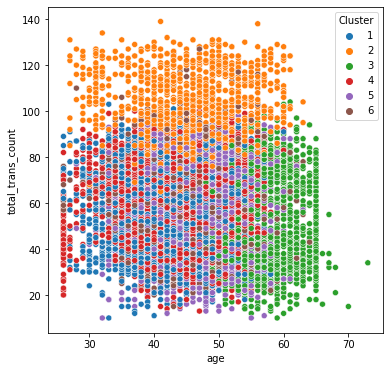

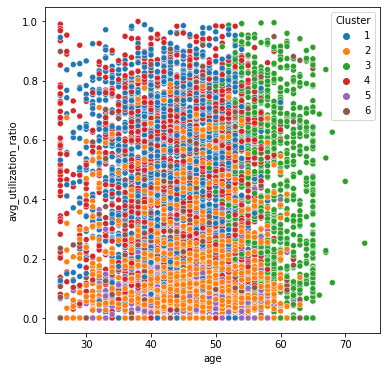

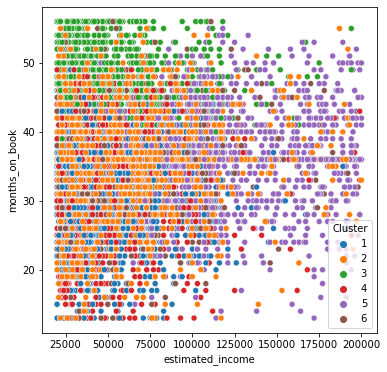

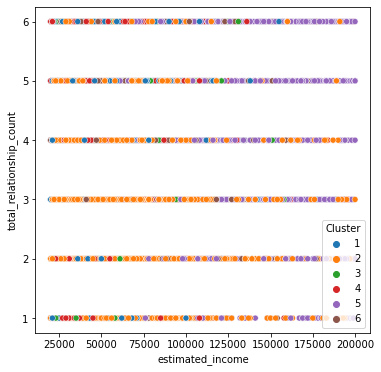

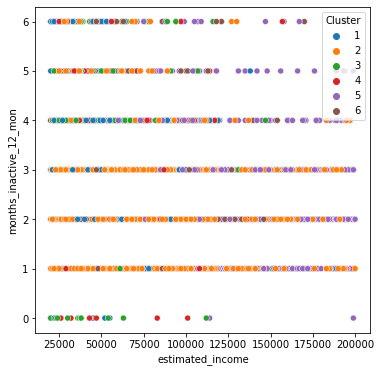

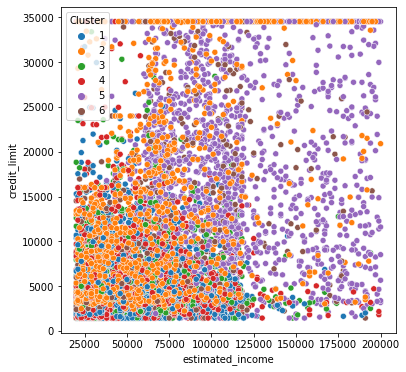

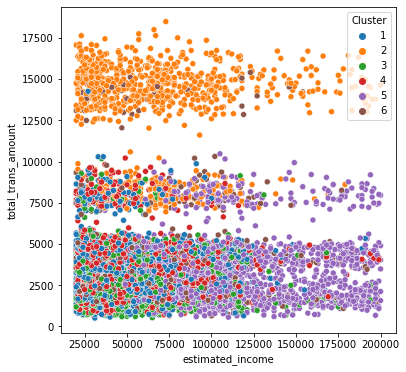

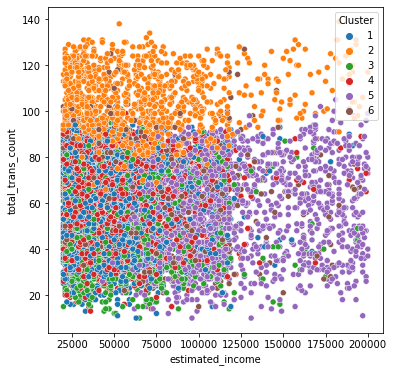

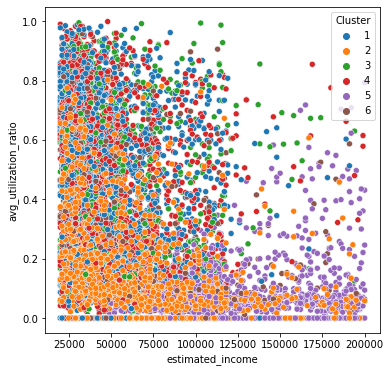

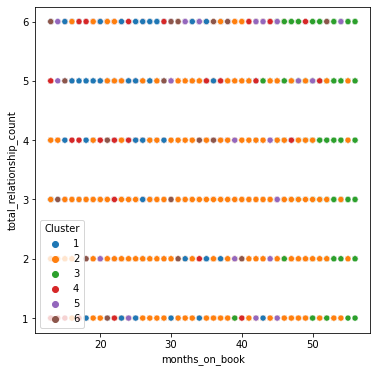

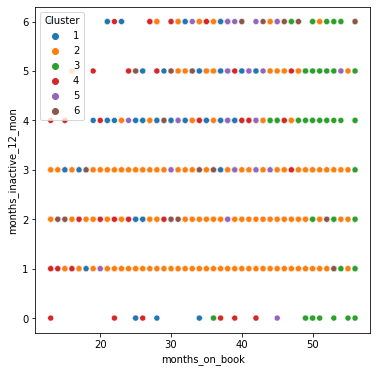

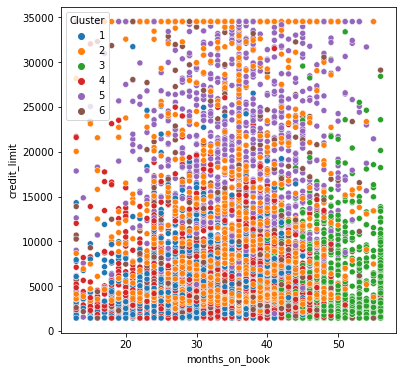

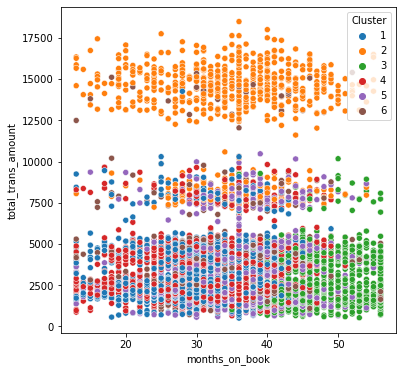

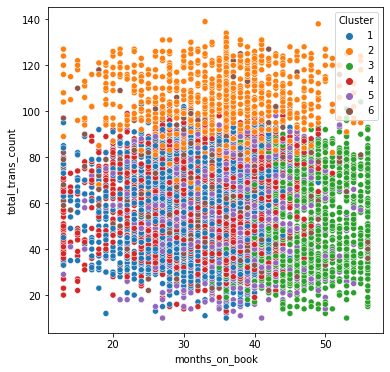

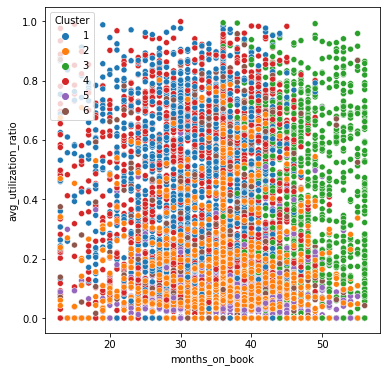

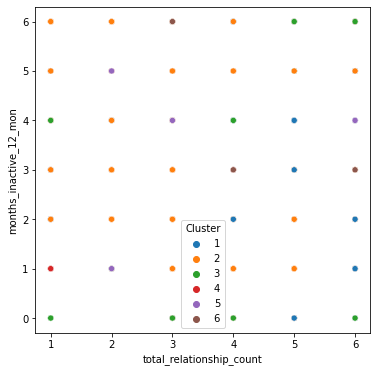

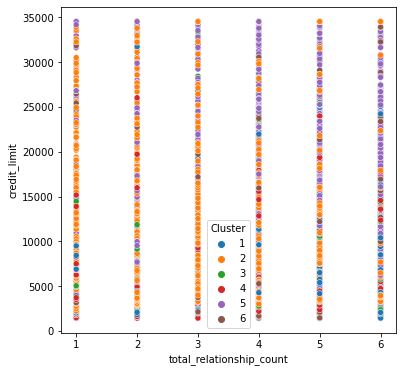

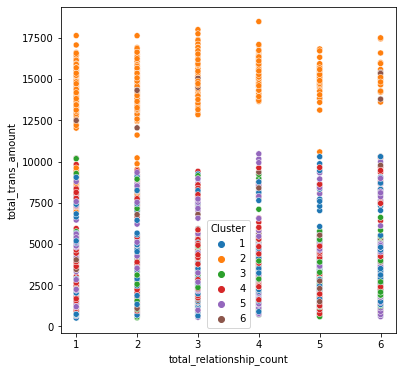

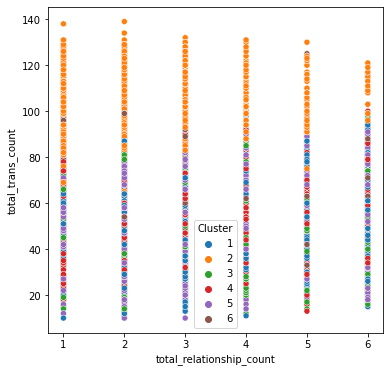

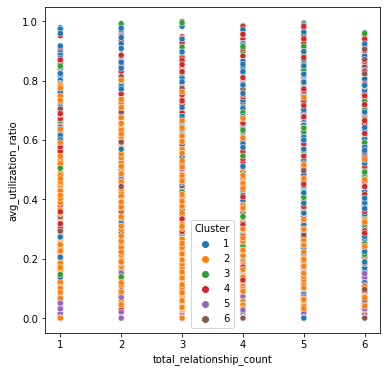

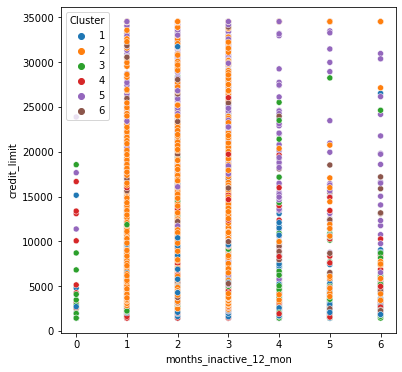

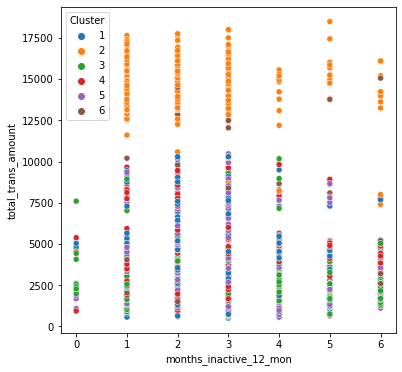

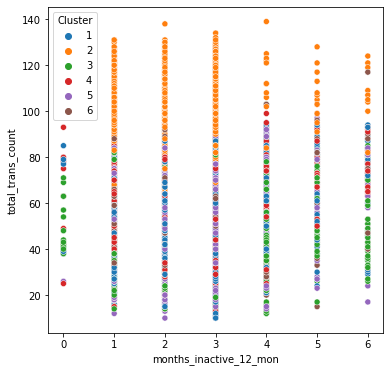

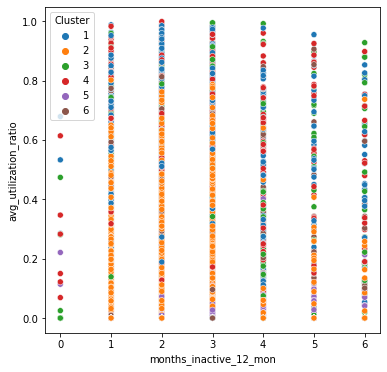

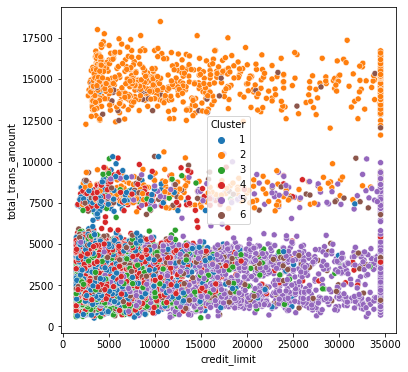

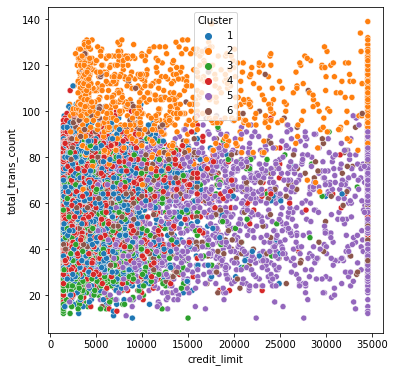

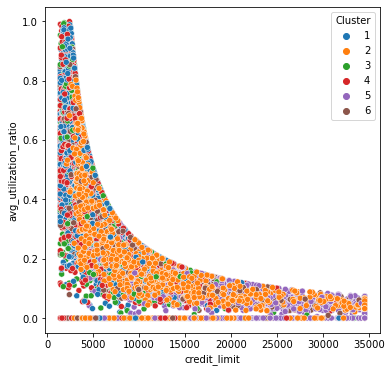

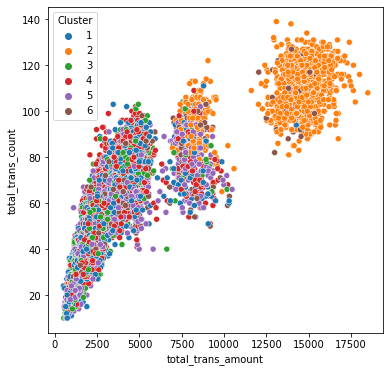

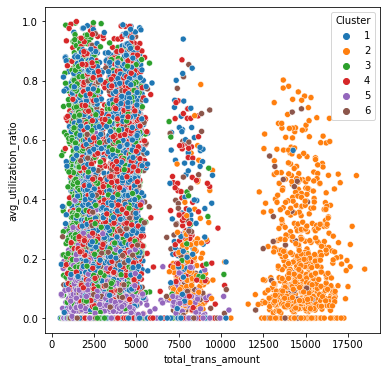

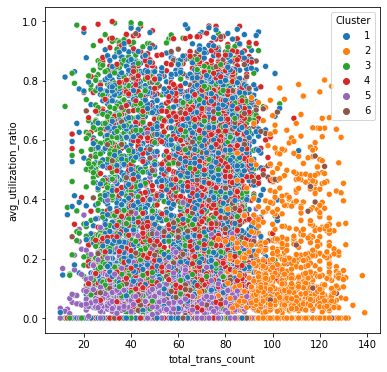

In [24]:
for i in range(0,len(numerical_vars)-1):
    for j in range(i+1,len(numerical_vars)):
        var1 = numerical_vars[i]
        var2 = numerical_vars[j]
        plt.figure(figsize=[6,6])
        sns.scatterplot(data=cc, x=var1, y=var2, hue='Cluster', palette='tab10')
        plt.show()

In [25]:
numerical_vars

['age',
 'estimated_income',
 'months_on_book',
 'total_relationship_count',
 'months_inactive_12_mon',
 'credit_limit',
 'total_trans_amount',
 'total_trans_count',
 'avg_utilization_ratio']

estimated_income
age


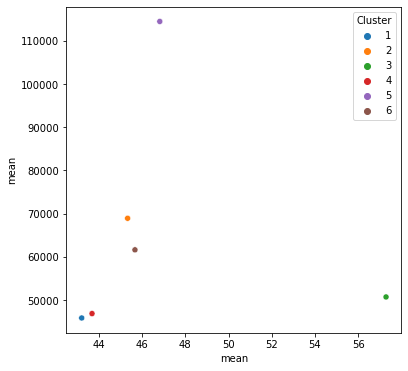

months_on_book
age


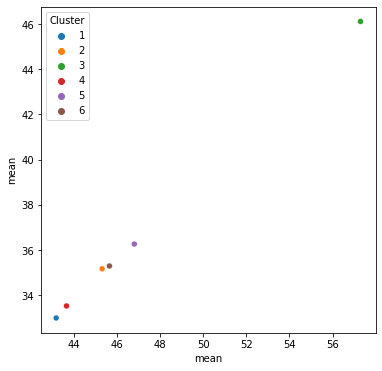

total_relationship_count
age


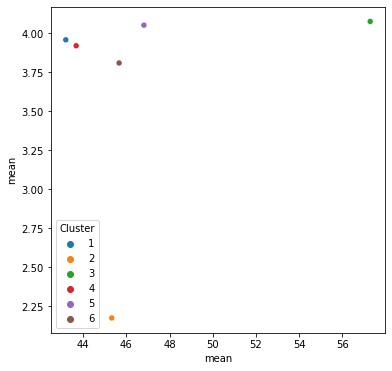

months_inactive_12_mon
age


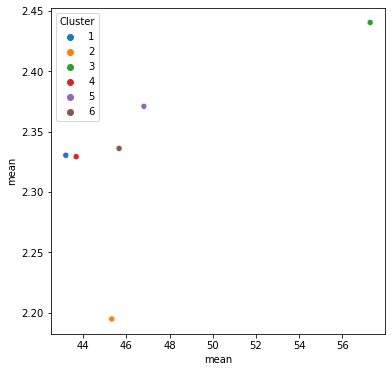

credit_limit
age


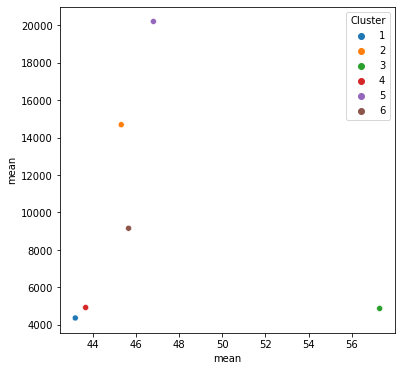

total_trans_amount
age


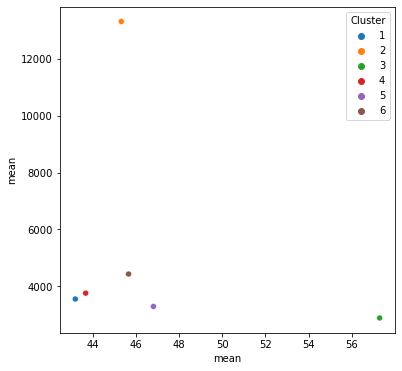

total_trans_count
age


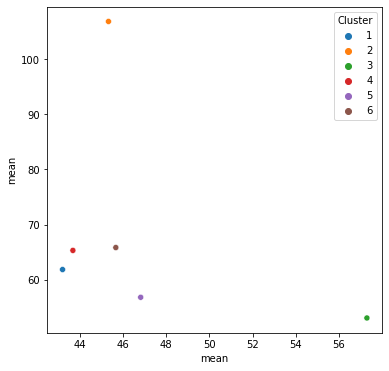

avg_utilization_ratio
age


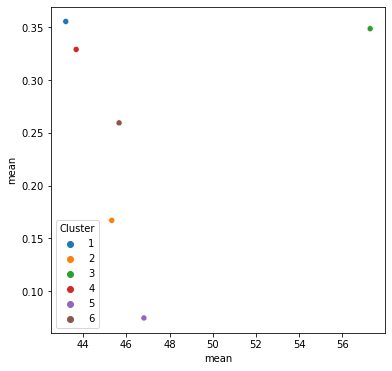

months_on_book
estimated_income


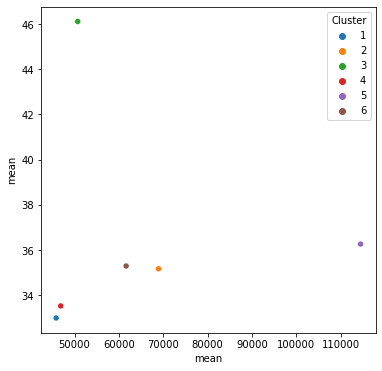

total_relationship_count
estimated_income


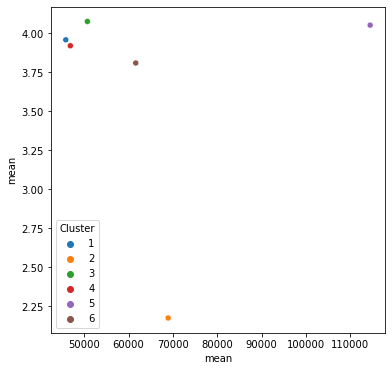

months_inactive_12_mon
estimated_income


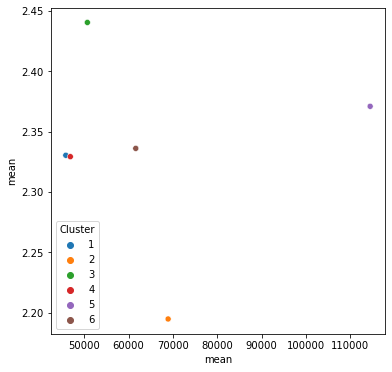

credit_limit
estimated_income


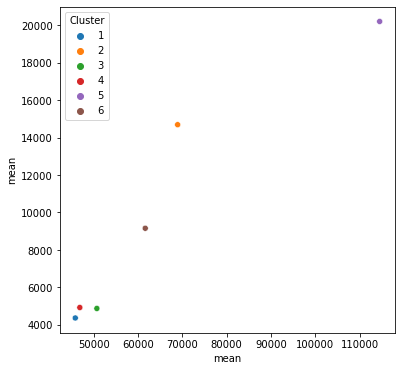

total_trans_amount
estimated_income


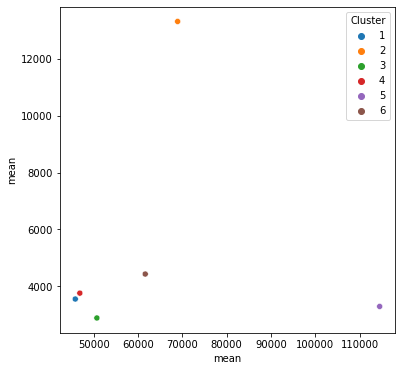

total_trans_count
estimated_income


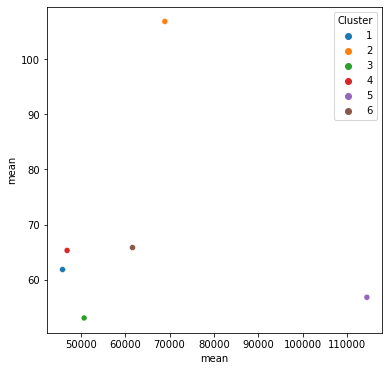

avg_utilization_ratio
estimated_income


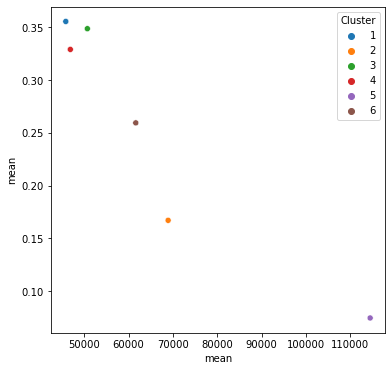

total_relationship_count
months_on_book


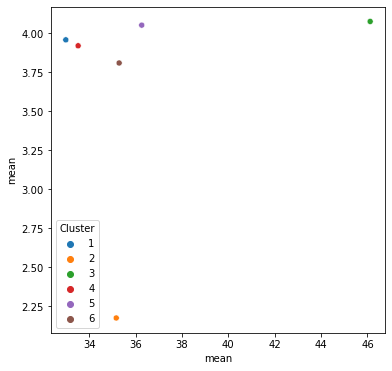

months_inactive_12_mon
months_on_book


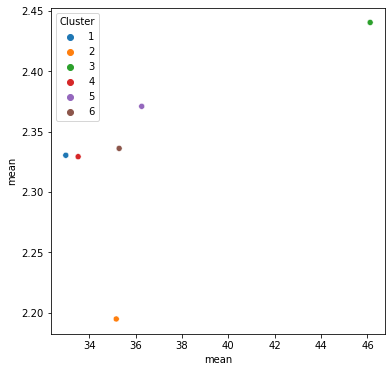

credit_limit
months_on_book


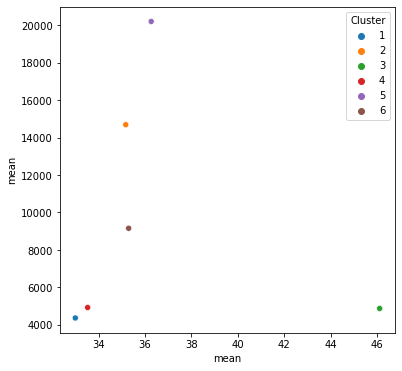

total_trans_amount
months_on_book


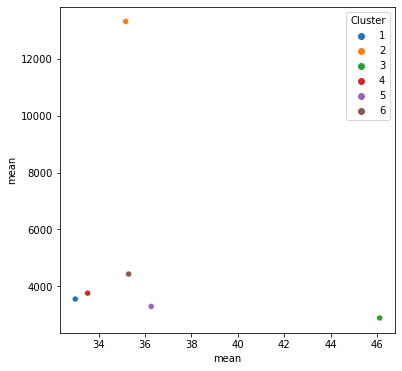

total_trans_count
months_on_book


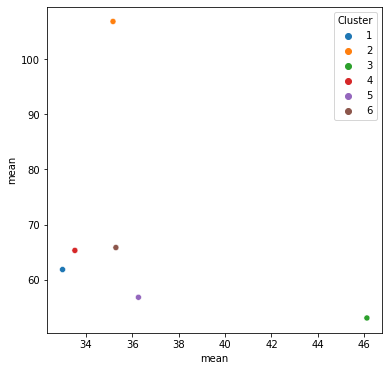

avg_utilization_ratio
months_on_book


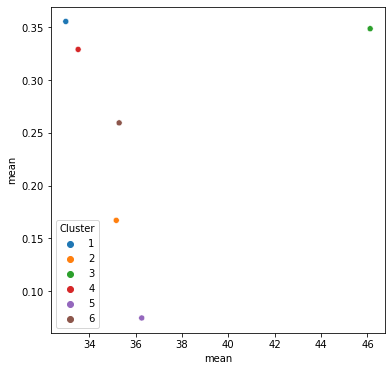

months_inactive_12_mon
total_relationship_count


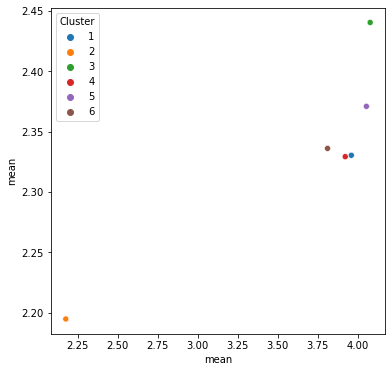

credit_limit
total_relationship_count


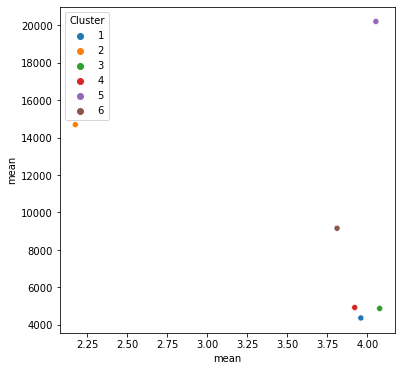

total_trans_amount
total_relationship_count


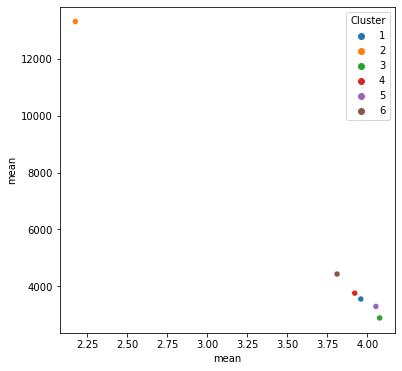

total_trans_count
total_relationship_count


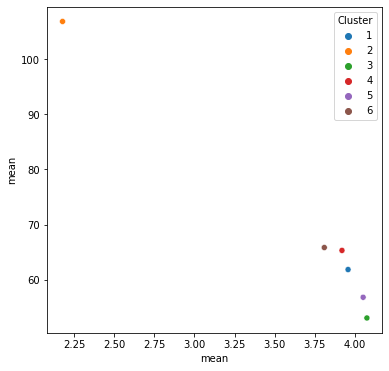

avg_utilization_ratio
total_relationship_count


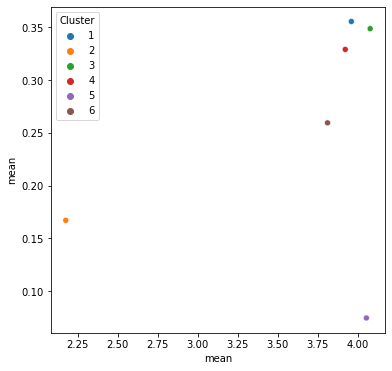

credit_limit
months_inactive_12_mon


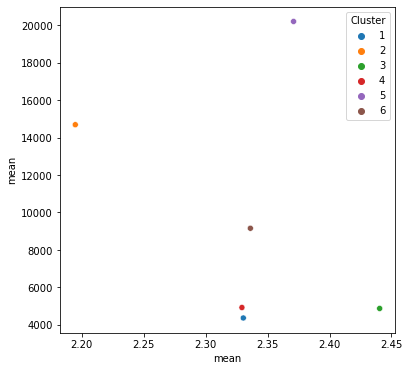

total_trans_amount
months_inactive_12_mon


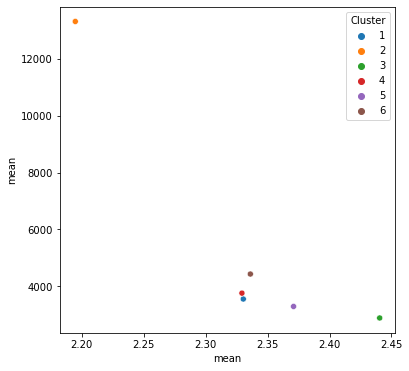

total_trans_count
months_inactive_12_mon


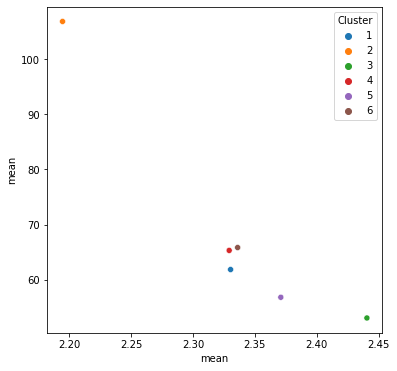

avg_utilization_ratio
months_inactive_12_mon


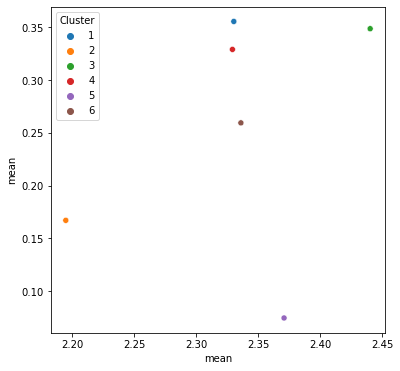

total_trans_amount
credit_limit


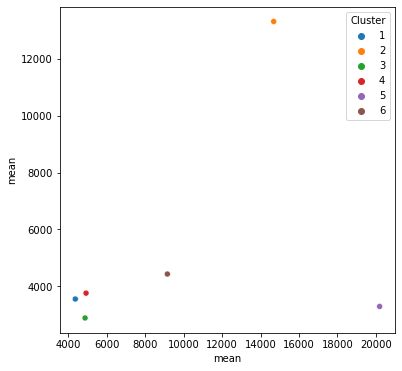

total_trans_count
credit_limit


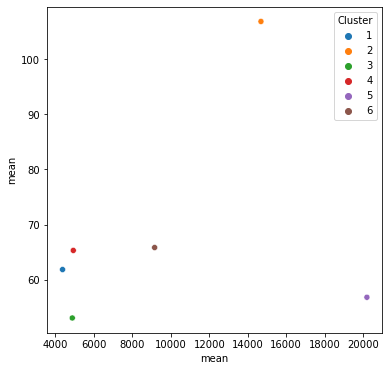

avg_utilization_ratio
credit_limit


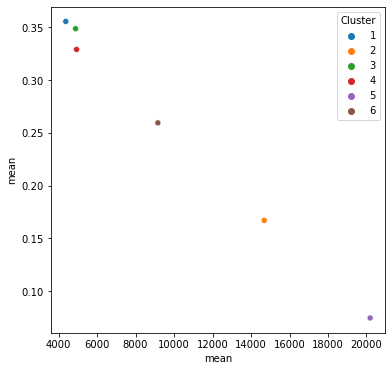

total_trans_count
total_trans_amount


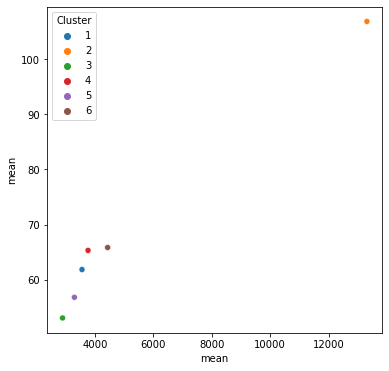

avg_utilization_ratio
total_trans_amount


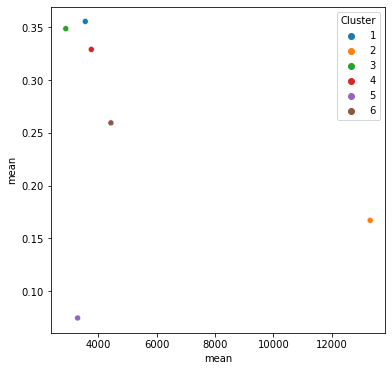

avg_utilization_ratio
total_trans_count


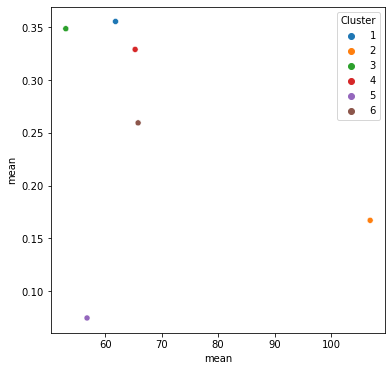

In [26]:
for i in range(0,len(numerical_vars)-1):
    for j in range(i+1,len(numerical_vars)):
        var1 = var_sums[numerical_vars[i]]
        var2 = var_sums[numerical_vars[j]]
        print(numerical_vars[j])
        print(numerical_vars[i])
        plt.figure(figsize=[6,6])
        sns.scatterplot(x=var1['mean'], y=var2['mean'], hue=var1.index, palette='tab10')
#         plt.xlabel(numerical_vars[i])
#         plt.ylabel(numerical_vars[j])
        plt.show()

Pairs of clusters do not do much beyond what the averages for each cluster did alone. It is clear looking at these plots that clusters 2 and 4 are very hard to distinguish on numerical variables. Cluster 1 often has a middling value that can be distinguished by pairs involving the following variables: credit limit, age, utilization ratio, relationship count, estimated income, months on book, months inactive. Middling values on this constellation of variables together may be the best definition of cluster 1.

Notes:

	* Clusters - numerical combos

		* 
1: middling position in credit limit x age, in utilization ratio x age, in relationship count x estimated income, months inactive x estimated income, credit limit x estimated income, utilization ratio x estimated income, credit limit x months on book, credit limit x total relationship count, credit limit x months inactive, several others
		* 
2: 
		* 
3: high income, low age; middling months on book, high income; high relationship count, high income; high credit limit, high estimated income; low utilization ratio, high income
		* 
4: 
		* 
5: high age, low income; high total relationship count, high age; high months inactive, high age; low credit limit, high age; low transaction amount & count, high age; high utilization ratio, high age; high months on book, low income; high relationship count, high months on book; high months inactive, high months on book; 
		* 
6: low total relationship count, low age; low months inactive, low age; high transaction amount & count, low age; low relationship count, medium income; low relationship count, low months on book; low months inactive, low months on book; 
	* 
fairly good sets of dimensions for distinguishing all:

		* 
months inactive x estimated income
		* 
total trans count, estimated income
		* 
credit limit, months on book
		* 
avg utilization ratio, months on book
		* 
credit limit, months inactive
		* 
avg utilization ratio, months inactive



## Conclusions

Our clusters of credit card customers can be distinguished by the following characteristics: 

- Cluster 1: unknown marital status, midding values on: credit limit, age, utilization ratio, relationship count, estimated income, months on book, months inactive
- Cluster 2: being married
- Cluster 3: predominately male, high average estimated income, high average credit limit, low average utilization ratio
- Cluster 4: being single
- Cluster 5: high average age, high average time as a customer (months on book).
- Cluster 6: low average amount contacting the company (total relationship count), high average total transaction count and amount 